# Flying insect activity-levels analysis
This notebook demonstrates analysis of flying insect activity levels data from camfi.

First, load the required libraries.

In [1]:
import bz2
import datetime
import gzip
import json

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import pandas as pd
from scipy.stats import linregress, chi2
import statsmodels.api as sm
import statsmodels.formula.api as smf

Next, load the image metadata (including annotations from VIA). It is in a json format with the following structure:

```
{
    "_via_attributes": {
        "file": {
            ...  # Contains default values for image metadata (EXIF) for VIA.
                 # The exact fields may vary with camera model.
        },
        "region": {},
    },
    "_via_img_metadata": {
        "<image_key>" : {
            "file_attributes": {
                ...  # Contains file-specific values for image metadata (EXIF)
            },
            "filename": ...,  # Path to imager file
            "regions": [...],  # List of annotations which have been made in VIA
            "size": -1
        },
    ...
    },
    "_via_settings": {
        ...  #  Contains project settings for VIA.
    }
}
```

Please see the camfi readme for instructions of how to create this file.

The `"_via_img_metadata"` part of the annotation file is the part of interest to us. In particular, we would like to extract the timestamp of the images and the `"regions"` list for each image. Below we load the data and list the names of the available EXIF fields.

In [2]:
# Modify the following line if using different dataset
data_path = "data/cabramurra_all_annotations.json.bz2"

def decompressed_open(filename, mode="r"):
    """
    Convenience wrapper to handle various types of compressed file. Assumes the filename suffix is correct.
    """
    if filename.endswith(".gz"):
        return gzip.open(filename, mode)
    elif filename.endswith(".bz2"):
        return bz2.open(filename, mode)
    else:
        return open(filename, mode)

with decompressed_open(data_path) as json_file:
    annotation = json.load(json_file)
    
image_keys = list(annotation["_via_img_metadata"].keys())

print("The available EXIF fields are:", "-" * 30, *annotation["_via_attributes"]["file"], sep="\n")

The available EXIF fields are:
------------------------------
datetime_original
exposure_time
pixel_x_dimension
pixel_y_dimension


With the data loaded, we can then make a summary of the number of annotations per image, as well as extracting the timestamp of the images from the camera's EXIF metadata. We will store this information in a Pandas dataframe.

From the above list of available EXIF metadata fields, we can see that the timestamp field is called `"DateTimeOriginal"`.

Note that a mistake was made when setting up camera 0004. Namely, the timestamps for all images from that camera are one month (31 days) behind. We will fix that now.

In [3]:
img_dates, filenames, n_annotations = [], [], []

for i, img_key in enumerate(image_keys):
    filename = annotation["_via_img_metadata"][img_key]["filename"]
    datetime_to_append = pd.to_datetime(
        annotation["_via_img_metadata"][img_key]["file_attributes"]["datetime_original"], format="%Y:%m:%d %H:%M:%S"
    )
    
    # Fixing incorrect timestamps. Comment the following two lines if using a different dataset:
    if "/0004/" in filename:
        datetime_to_append += pd.to_timedelta(31, "D")
        
    img_dates.append(datetime_to_append)
    filenames.append(filename)
    n_annotations.append(len(annotation["_via_img_metadata"][img_key]["regions"]))    
    
df = pd.DataFrame(
    data=dict(
        timestamp=img_dates,
        filename=filenames,
        n_annotations=n_annotations,
    ),
)
df.set_index("timestamp", drop=False, inplace=True)

df.sort_index(inplace=True)

print(f"Total annotations: {df['n_annotations'].sum()}")

df

Total annotations: 1419


,timestamp,filename,n_annotations
timestamp,,,
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0001/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0004/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0003/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0007/DSCF0001.JPG,0
2019-11-14 19:00:03,2019-11-14 19:00:03,2019-11_cabramurra/0009/DSCF0001.JPG,0
...,...,...,...
2019-11-26 06:53:38,2019-11-26 06:53:38,2019-11_cabramurra/0008/DSCF0864.JPG,0
2019-11-26 06:53:38,2019-11-26 06:53:38,2019-11_cabramurra/0007/DSCF0864.JPG,0
2019-11-26 06:53:38,2019-11-26 06:53:38,2019-11_cabramurra/0001/DSCF0864.JPG,0


To get a general overview of the activity levels observed throughout the study period, we pool the data from all cameras and plot the number of annotations per 10-minute interval:

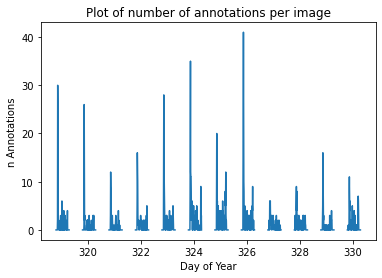

In [4]:
df["dayofyear"] = df["timestamp"].dt.dayofyear + \
                  df["timestamp"].dt.hour.values / 24 + \
                  df["timestamp"].dt.minute.values / 1440

fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Plot of number of annotations per image",
    ylabel="n Annotations",
    xlabel="Day of Year"
)

h, bx, by = np.histogram2d(
    df["dayofyear"],
    df["n_annotations"],
    bins = [
        np.arange(min(df["dayofyear"]) - 1 / 288, max(df["dayofyear"]) + 1 / 288, 1 / 144),
        np.arange(-0.5, max(df["n_annotations"]) + 1, 1)
    ]
)

b_midpoints = (bx[:-1] + bx[1:]) / 2

n_annotations_per10min = (h * np.arange(h.shape[1]).reshape((1, h.shape[1]))).sum(axis=1)
n_annotations_per10min[h.sum(axis=1) == 0.] = np.nan

p = ax.plot(b_midpoints, n_annotations_per10min)

The gaps in the above figure are periods where the cameras were not set to take photos (they were only set to take photos between the hours of 19:00-07:00 AEDT each night).

There seems to be a periodic signal in the data, with more activity in the evening. We can take a closer look at this by pooling the data from all days into a single representative 24-hour period.

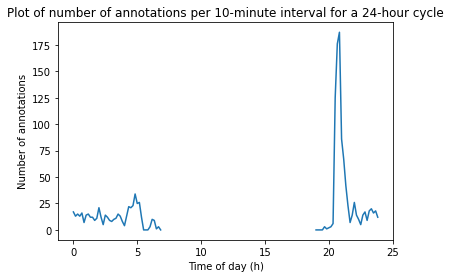

In [5]:
df["dayhour"] = (df["dayofyear"] - np.floor(df["dayofyear"])) * 24.

fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Plot of number of annotations per 10-minute interval for a 24-hour cycle",
    ylabel="Number of annotations",
    xlabel="Time of day (h)"
)

h24, bx24, by24 = np.histogram2d(
    df["dayhour"],
    df["n_annotations"],
    bins = [
        np.arange(-1 / 12, 24 + 1 / 6, 1 / 6),
        np.arange(-0.5, max(df["n_annotations"]) + 1, 1)
    ]
)

b24_midpoints = (bx24[:-1] + bx24[1:]) / 2

n_annotations_per10min24 = (h24 * np.arange(h24.shape[1]).reshape((1, h24.shape[1]))).sum(axis=1)
n_annotations_per10min24[h24.sum(axis=1) == 0.] = np.nan

p = ax.plot(b24_midpoints, n_annotations_per10min24)

In the above figure we see a striking increase in activity levels during the hours of 20:20-21:20. This seems to be when the most insects are flying.

Taking the mean number of annotations per image during this period for each day, we can then look at how activity levels were across the days of the study period. Next, we merge these daily activity levels with daily temperature data from the Bureau of Meterology.

In [6]:
# Summarising evening activity across each study day
df_maelstrom = df[(df.dayhour >= 20 + 20 / 60) & (df.dayhour < 21 + 20 / 60)]
maelstrom_intensity = df_maelstrom.groupby(df_maelstrom["timestamp"].dt.date)["n_annotations"].sum()
maelstrom_intensity = pd.DataFrame(maelstrom_intensity)
maelstrom_intensity["date"] = pd.to_datetime(maelstrom_intensity.index)

# Loading weather data
weather_data_path = "data/cabramurra_bom_weather_201911.csv"
weather_df = pd.read_csv(weather_data_path, skiprows=6, header=0)
weather_df["date"] = pd.to_datetime(weather_df["date"])
for timekey in [
    "sunrise",
    "sunset",
    "astronomical_twilight_start",
    "astronomical_twilight_end",
    "nautical_twilight_start",
    "nautical_twilight_end",
    "civil_twilight_start",
    "civil_twilight_end",
    "solar_noon"
]:
    weather_df[timekey] = pd.to_datetime(weather_df[timekey]).dt.hour + pd.to_datetime(weather_df[timekey]).dt.minute / 60

# temperature_minimum_degC is taken from the 24h until 9am.
# We are interested in the minimum temperature in the 24h from 9am.
weather_df["temperature_minimum_evening_degC"] = np.nan
weather_df.loc[:28, "temperature_minimum_evening_degC"] = weather_df["temperature_minimum_degC"][1:].array

# Database merge of evening activity and daily weather data
maelstrom_weather = maelstrom_intensity.merge(
    weather_df,
    how="left",
    on="date",
)

# Include dayofyear in maelstrom_weather
maelstrom_weather["dayofyear"] = maelstrom_weather.date.dt.dayofyear

maelstrom_weather

,n_annotations,date,temperature_minimum_degC,temperature_maximum_degC,rainfall_mm,maximum_wind_gust_direction,maximum_wind_gust_speed_kph,maximum_wind_gust_time,temperature_9am_degC,relative_humidity_9am_pc,...,sunset,astronomical_twilight_start,astronomical_twilight_end,nautical_twilight_start,nautical_twilight_end,civil_twilight_start,civil_twilight_end,solar_noon,temperature_minimum_evening_degC,dayofyear
0,78,2019-11-14,-0.6,12.3,0.0,W,41,23:04,4.9,95,...,15.833333,4.200000,21.500000,4.816667,20.883333,5.383333,20.300000,12.833333,4.7,318
1,42,2019-11-15,4.7,13.8,0.0,WNW,70,12:54,8.3,73,...,15.850000,4.183333,21.516667,4.800000,20.900000,5.366667,20.316667,12.833333,3.7,319
2,35,2019-11-16,3.7,14.3,0.0,WNW,48,16:22,5.9,69,...,15.866667,4.166667,21.533333,4.783333,20.916667,5.350000,20.333333,12.850000,3.3,320
3,48,2019-11-17,3.3,14.3,0.0,WNW,33,12:48,8.4,42,...,15.883333,4.150000,21.566667,4.766667,20.933333,5.350000,20.350000,12.850000,4.5,321
4,73,2019-11-18,4.5,16.0,0.0,WNW,43,15:49,7.6,45,...,15.900000,4.133333,21.583333,4.750000,20.950000,5.333333,20.383333,12.850000,7.5,322
5,86,2019-11-19,7.5,21.7,0.0,WNW,65,12:28,13.0,41,...,15.916667,4.116667,21.616667,4.733333,20.983333,5.316667,20.400000,12.850000,11.0,323
6,55,2019-11-20,11.0,23.1,0.0,WNW,31,13:41,15.0,31,...,15.933333,4.100000,21.633333,4.733333,21.000000,5.316667,20.416667,12.850000,15.0,324
7,108,2019-11-21,15.0,27.6,0.0,NNW,50,13:43,22.0,27,...,15.950000,4.083333,21.650000,4.716667,21.016667,5.300000,20.433333,12.866667,17.2,325
8,22,2019-11-22,17.2,22.6,0.0,NNW,54,23:22,19.8,34,...,15.966667,4.066667,21.683333,4.700000,21.033333,5.283333,20.450000,12.866667,11.3,326
9,33,2019-11-23,11.3,20.0,0.0,WNW,43,12:53,13.9,36,...,15.983333,4.050000,21.700000,4.683333,21.066667,5.283333,20.466667,12.866667,8.2,327


Now we can plot these data:

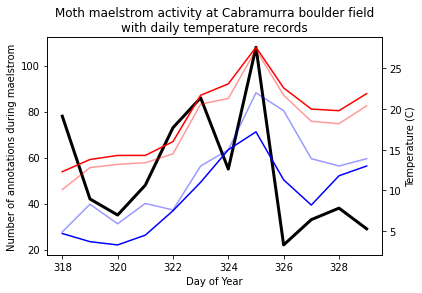

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(
    111,
    title="Moth maelstrom activity at Cabramurra boulder field\nwith daily temperature records",
    ylabel="Number of annotations during maelstrom",
    xlabel="Day of Year",
)
ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (C)")

# Plotting insect evening activity levels
ax1.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["n_annotations"],
    c="k",
    lw=3,
    label="Bogong moth maelstrom activity",
)

# Plotting daily temperature data
ax2.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_maximum_degC"],
    c="r",
    label="Maximum temperature (C)",
)
ax2.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_3pm_degC"],
    c="r",
    alpha=0.4,
    label="3pm Temperature (C)",
)
ax2.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_minimum_evening_degC"],
    c="b",
    label="Minimum temperature (C)",
)
ax2.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_9am_degC"],
    c="b",
    alpha=0.4,
    label="9am Temperature (C)",
)

Finally, we can combine the above plots into a single figure:

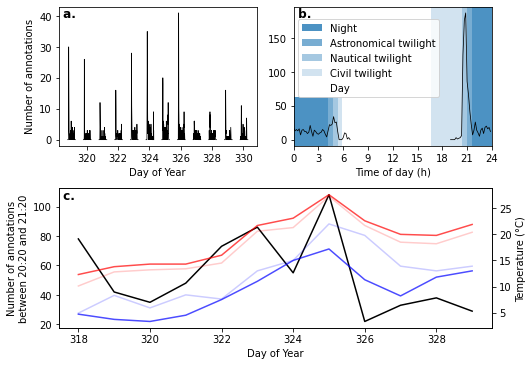

In [8]:
b_legend_loc = 0.02, 0.35

fig = plt.figure(
    figsize=(7.5, 5.2),
    #dpi=1000.0,
    tight_layout=True,
)
title_y = 0.88

ax1 = fig.add_subplot(
    221,
    xlabel="Day of Year",
    ylabel="Number of annotations",
)
ax1.set_title(" a.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax1.plot(b_midpoints, n_annotations_per10min, c="k", lw=0.75)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2 = fig.add_subplot(
    222,
    xlabel="Time of day (h)",
    xlim=(0., 24.),
)
ax2.plot(b24_midpoints, n_annotations_per10min24, c="k", lw=0.75)

ax2.axvspan(
    0.,
    maelstrom_weather["astronomical_twilight_start"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.8,
    label="Night",
)

ax2.axvspan(
    maelstrom_weather["astronomical_twilight_start"].mean(),
    maelstrom_weather["nautical_twilight_start"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.6,
    label="Astronomical twilight",
)

ax2.axvspan(
    maelstrom_weather["nautical_twilight_start"].mean(),
    maelstrom_weather["civil_twilight_start"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.4,
    label="Nautical twilight",
)

ax2.axvspan(
    maelstrom_weather["civil_twilight_start"].mean(),
    maelstrom_weather["sunrise"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.2,
    label="Civil twilight",
)

ax2.axvspan(
    maelstrom_weather["sunrise"].mean(),
    maelstrom_weather["sunset"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.,
    label="Day",
)

ax2.axvspan(
    maelstrom_weather["astronomical_twilight_end"].mean(),
    24.,
    alpha=0.8,
)

ax2.axvspan(
    maelstrom_weather["nautical_twilight_end"].mean(),
    maelstrom_weather["astronomical_twilight_end"].mean(),
    alpha=0.6,
)

ax2.axvspan(
    
    maelstrom_weather["civil_twilight_end"].mean(),
    maelstrom_weather["nautical_twilight_end"].mean(),
    alpha=0.4,
)

ax2.axvspan(
    maelstrom_weather["sunset"].mean(),
    maelstrom_weather["civil_twilight_end"].mean(),
    alpha=0.2,
)

ax2.legend(loc=b_legend_loc)
ax2.set_title(" b.", fontdict={"fontweight": "bold"}, loc="left", y=title_y, zorder=10)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

ax3 = fig.add_subplot(
    212,
    xlabel="Day of Year",
    ylabel="Number of annotations\nbetween 20:20 and 21:20",    
)
ax3.set_title(" c.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax3.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["n_annotations"],
    c="k",
    label="Bogong moth maelstrom activity",
)

ax4 = ax3.twinx()
ax4.set_ylabel("Temperature (°C)")
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_maximum_degC"],
    c="r",
    alpha=0.7,
    label="Maximum temperature (C)",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_3pm_degC"],
    c="r",
    alpha=0.2,
    label="3pm Temperature (C)",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_minimum_evening_degC"],
    c="b",
    alpha=0.7,
    label="Minimum temperature (C)",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_9am_degC"],
    c="b",
    alpha=0.2,
    label="9am Temperature (C)",
)

We then may like to regress the activity levels against various factors. Given the activity level count data, we can proceed using a Poisson regression of `n_annotations` vs. the independent variables of interest.

First, we will select non-correlated covariates from `maelstrom_weather`. Here we can add derived covariates, such as `temperature_range` and `dewpoint_degC`.

In [9]:
maelstrom_weather["temperature_range"] = maelstrom_weather.temperature_maximum_degC - maelstrom_weather.temperature_minimum_evening_degC
maelstrom_weather["dewpoint_3pm_degC"] = mpcalc.dewpoint_from_relative_humidity(
    units.Quantity(maelstrom_weather["temperature_3pm_degC"].array, "degC"),
    units.Quantity(maelstrom_weather["relative_humidity_3pm_pc"].array, "percent"),
)
list(maelstrom_weather.columns)

['n_annotations',
 'date',
 'temperature_minimum_degC',
 'temperature_maximum_degC',
 'rainfall_mm',
 'maximum_wind_gust_direction',
 'maximum_wind_gust_speed_kph',
 'maximum_wind_gust_time',
 'temperature_9am_degC',
 'relative_humidity_9am_pc',
 'cloud_amount_9am_oktas',
 'wind_direction_9am',
 'wind_speed_9am_kph',
 'temperature_3pm_degC',
 'relative_humidity_3pm_pc',
 'wind_direction_3pm',
 'wind_speed_3pm_kph',
 'sunrise',
 'sunset',
 'astronomical_twilight_start',
 'astronomical_twilight_end',
 'nautical_twilight_start',
 'nautical_twilight_end',
 'civil_twilight_start',
 'civil_twilight_end',
 'solar_noon',
 'temperature_minimum_evening_degC',
 'dayofyear',
 'temperature_range',
 'dewpoint_3pm_degC']

We will comment out the ones we don't want to use, then plot the pairs to make sure we haven't missed any glaringly corrrelated covariates

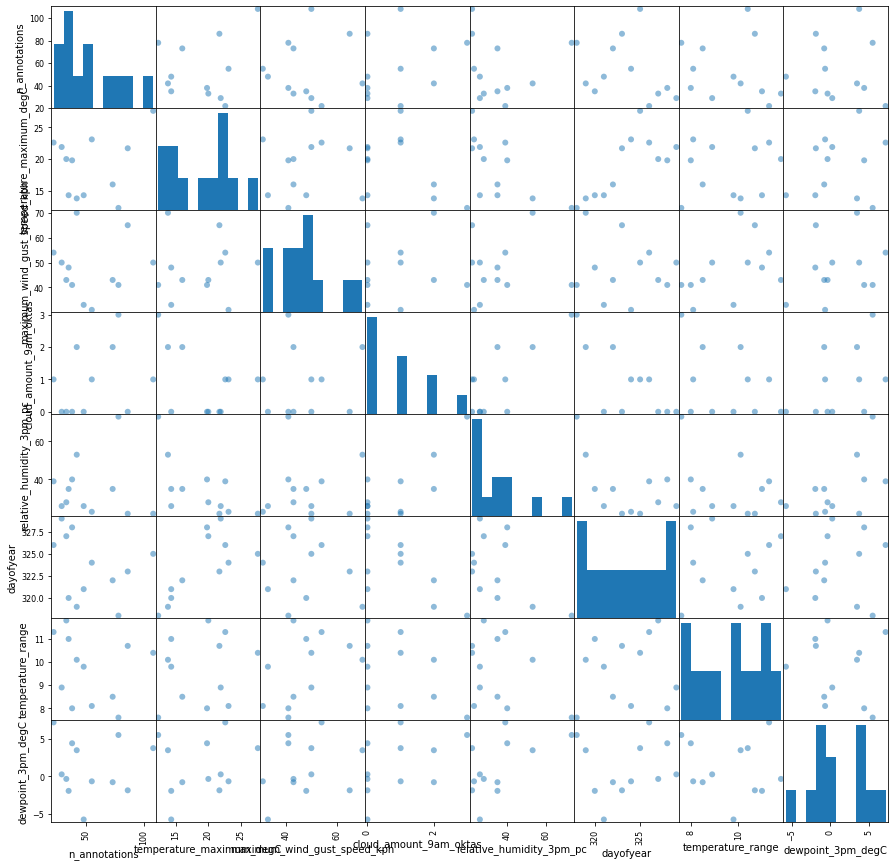

In [10]:
covariates = [
    #"date",                        # Use dayofyear instead
    #"temperature_minimum_degC",    # Correlated with temperature_maximum_degC
    "temperature_maximum_degC",
    #"rainfall_mm",                 # All of these are 0. in our data
    "maximum_wind_gust_speed_kph",
    #"temperature_9am_degC",        # Correlated with temperature_maximum_degC
    #"relative_humidity_9am_pc",    # Correlated with relative_humidity_3pm_pc
    "cloud_amount_9am_oktas",
    #"wind_direction_9am",          # Wind direction did not vary much over the experiment
    #"wind_speed_9am_kph",          # Correlated with maximum_wind_gust_speed_kph
    #"temperature_3pm_degC",        # Correlated with temperature_maximum_degC
    "relative_humidity_3pm_pc",
    #"wind_direction_3pm",          # Wind direction did not vary much over the experiment
    #"wind_speed_3pm_kph",          # Correlated with maximum_wind_gust_speed_kph
    "dayofyear",
    "temperature_range",
    "dewpoint_3pm_degC",
]

grr = pd.plotting.scatter_matrix(
    maelstrom_weather[["n_annotations", *covariates]],
    marker='o',
    figsize=(15, 15),
)

Fitting a Poisson GLM of `n_annotations` vs. each covariate individually, and plotting the effect:

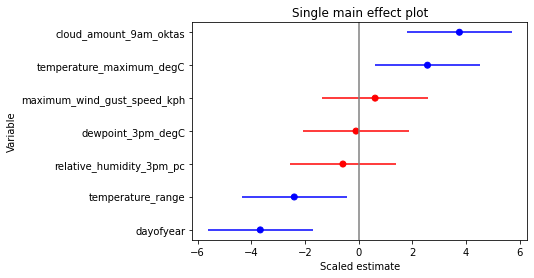

In [11]:
pois = sm.families.Poisson()

tvalues = []
pvalues = []
for covariate in covariates:
    mod = smf.glm(
        f"n_annotations ~ {covariate}",
        data=maelstrom_weather,
        family=pois,
    )
    res = mod.fit()
    tvalues.append(res.tvalues[1])
    pvalues.append(res.pvalues[1])
    
tvalues = np.array(tvalues)
pvalues = np.array(pvalues)

ordering = np.argsort(tvalues)
coloring = np.array(["r", "b"])[(pvalues[ordering] < 0.05).astype("u1")]

fig = plt.figure()
ax = fig.add_subplot(
    111,
    title="Single main effect plot",
    xlabel="Scaled estimate",
    ylabel="Variable",
)
ax.axvline(0, c="gray")
ax.hlines(np.array(covariates)[ordering], tvalues[ordering] - 1.96, tvalues[ordering] + 1.96, color=coloring)
p = ax.scatter(tvalues[ordering], np.array(covariates)[ordering], color=coloring)

Fitting a Poisson GLM of `n_annotations` vs. all of the covariates, and plotting the effect:

                 Generalized Linear Model Regression Results                  
Dep. Variable:          n_annotations   No. Observations:                   11
Model:                            GLM   Df Residuals:                        3
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51.152
Date:                Thu, 13 May 2021   Deviance:                       39.053
Time:                        16:47:04   Pearson chi2:                     37.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

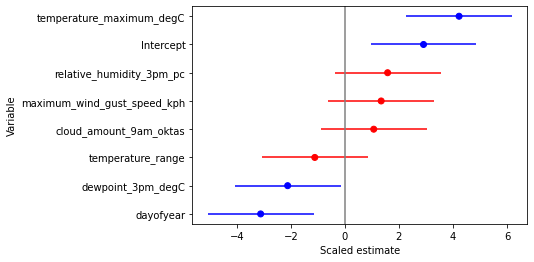

In [12]:
mod = smf.glm(
    "n_annotations ~ " + " + ".join(covariates),
    data=maelstrom_weather,
    family=pois,
)
res = mod.fit()
print(res.summary())
print(f"{res.aic=}")

ordering = np.argsort(res.tvalues)
coloring = np.array(["r", "b"])[(res.pvalues[ordering] < 0.05).astype("u1")]

fig = plt.figure()
ax = fig.add_subplot(
    111,
    xlabel="Scaled estimate",
    ylabel="Variable",
)
ax.axvline(0, c="gray")
ax.hlines(res.tvalues.index[ordering], res.tvalues[ordering] - 1.96, res.tvalues[ordering] + 1.96, color=coloring)
p = ax.scatter(res.tvalues[ordering], res.tvalues.index[ordering], color=coloring)

We can see that in both cases, `temperature_maximum_degC` has the largest effect `n_annotations` of all of the weather variables. Here we fit the Poisson regression model `n_annotations ~ temperature_maximum_degC`, which can be interpreted as "Moth activity level scales with maximum temperature".

In [13]:
mod = smf.glm(
    "n_annotations ~ temperature_maximum_degC",
    data=maelstrom_weather,
    family=pois,
)
res = mod.fit()
print(res.summary())
print("p-values (t-test):", res.pvalues, sep="\n")
print("t-values:", res.tvalues, sep="\n")
print(f"{res.aic=}")
print(res.wald_test("(temperature_maximum_degC = 0)"))

                 Generalized Linear Model Regression Results                  
Dep. Variable:          n_annotations   No. Observations:                   12
Model:                            GLM   Df Residuals:                       10
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -99.853
Date:                Thu, 13 May 2021   Deviance:                       131.06
Time:                        16:47:04   Pearson chi2:                     130.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

We may also be interested in extending this model to allow for the date to affect the moth activity levels (i.e. due to moths arriving or leaving the locale):

In [14]:
mod = smf.glm(
    "n_annotations ~ temperature_maximum_degC + dayofyear",
    data=maelstrom_weather,
    family=pois,
)
res = mod.fit()
print(res.summary())
print("p-values (t-test):", res.pvalues, sep="\n")
print("t-values:", res.tvalues, sep="\n")
print(f"{res.aic=}")
print(res.wald_test("(temperature_maximum_degC = 0), (dayofyear = 0)"))

                 Generalized Linear Model Regression Results                  
Dep. Variable:          n_annotations   No. Observations:                   12
Model:                            GLM   Df Residuals:                        9
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -65.144
Date:                Thu, 13 May 2021   Deviance:                       61.639
Time:                        16:47:04   Pearson chi2:                     58.5
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Note that the above model fits the data much better, while only adding one parameter.

To check that nothing strange is going on, we can plot the residuals:

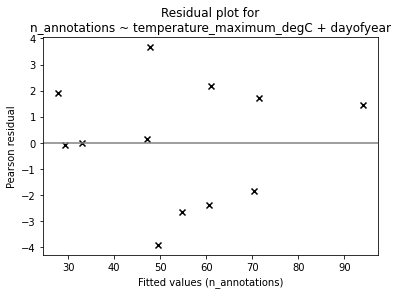

In [15]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    title=f"Residual plot for\n{mod.formula}",
    ylabel="Pearson residual",
    xlabel="Fitted values (n_annotations)",
)

ax.axhline(0, c="gray")
p = ax.scatter(res.fittedvalues, res.resid_pearson, marker="x", c="k")

And finally, we can re-plot subfigure **c.** from above, this time including the predicted values for `n_annotations`.

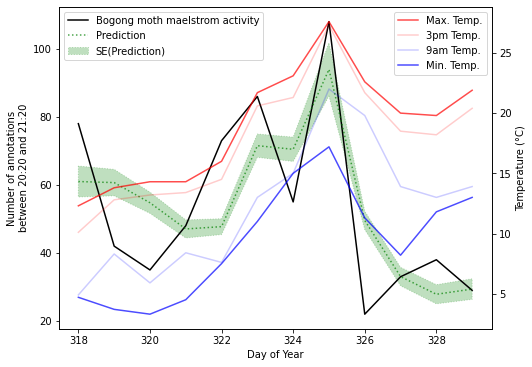

In [16]:
prediction = res.get_prediction()

fig = plt.figure(
    figsize=(7.5, 5.2),
    #dpi=1000.0,
    tight_layout=True,
)

ax3 = fig.add_subplot(
    111,
    xlabel="Day of Year",
    ylabel="Number of annotations\nbetween 20:20 and 21:20",    
)
ax3.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["n_annotations"],
    c="k",
    label="Bogong moth maelstrom activity",
)

ax4 = ax3.twinx()
ax4.set_ylabel("Temperature (°C)")
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_maximum_degC"],
    c="r",
    alpha=0.7,
    label="Max. Temp.",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_3pm_degC"],
    c="r",
    alpha=0.2,
    label="3pm Temp.",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_9am_degC"],
    c="b",
    alpha=0.2,
    label="9am Temp.",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_minimum_evening_degC"],
    c="b",
    alpha=0.7,
    label="Min. Temp.",
)

ax3.fill_between(
    maelstrom_weather["dayofyear"],
    prediction.predicted_mean - prediction.se_mean,
    prediction.predicted_mean + prediction.se_mean,
    color="g",
    alpha=0.25,
    linestyle="dotted",
    label="SE(Prediction)",
)
ax3.plot(
    maelstrom_weather["dayofyear"],
    prediction.predicted_mean,
    c="g",
    alpha=0.7,
    linestyle="dotted",
    label="Prediction",
)

ax3.legend(loc="upper left")
ax4.legend(loc="upper right")

Putting it all together for the publication:

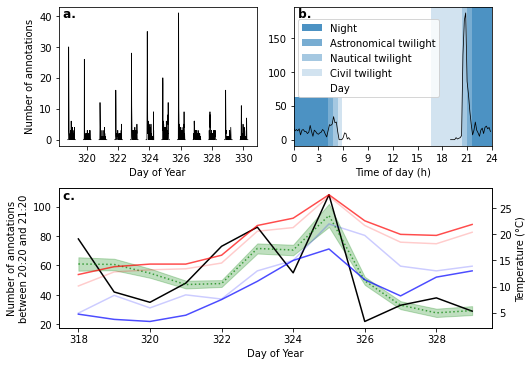

In [17]:
fig = plt.figure(
    figsize=(7.5, 5.2),
    #dpi=1000.0,
    tight_layout=True,
)
title_y = 0.88

ax1 = fig.add_subplot(
    221,
    xlabel="Day of Year",
    ylabel="Number of annotations",
)
ax1.set_title(" a.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax1.plot(b_midpoints, n_annotations_per10min, c="k", lw=0.75)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2 = fig.add_subplot(
    222,
    xlabel="Time of day (h)",
    xlim=(0., 24.),
)

ax2.plot(b24_midpoints, n_annotations_per10min24, c="k", lw=0.75)

ax2.axvspan(
    0.,
    maelstrom_weather["astronomical_twilight_start"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.8,
    label="Night",
)

ax2.axvspan(
    maelstrom_weather["astronomical_twilight_start"].mean(),
    maelstrom_weather["nautical_twilight_start"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.6,
    label="Astronomical twilight",
)

ax2.axvspan(
    maelstrom_weather["nautical_twilight_start"].mean(),
    maelstrom_weather["civil_twilight_start"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.4,
    label="Nautical twilight",
)

ax2.axvspan(
    maelstrom_weather["civil_twilight_start"].mean(),
    maelstrom_weather["sunrise"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.2,
    label="Civil twilight",
)

ax2.axvspan(
    maelstrom_weather["sunrise"].mean(),
    maelstrom_weather["sunset"].mean(),
    ymax=b_legend_loc[1],
    alpha=0.,
    label="Day",
)

ax2.axvspan(
    maelstrom_weather["astronomical_twilight_end"].mean(),
    24.,
    alpha=0.8,
)

ax2.axvspan(
    maelstrom_weather["nautical_twilight_end"].mean(),
    maelstrom_weather["astronomical_twilight_end"].mean(),
    alpha=0.6,
)

ax2.axvspan(
    
    maelstrom_weather["civil_twilight_end"].mean(),
    maelstrom_weather["nautical_twilight_end"].mean(),
    alpha=0.4,
)

ax2.axvspan(
    maelstrom_weather["sunset"].mean(),
    maelstrom_weather["civil_twilight_end"].mean(),
    alpha=0.2,
)

ax2.legend(loc=b_legend_loc)
ax2.set_title(" b.", fontdict={"fontweight": "bold"}, loc="left", y=title_y, zorder=10)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

ax3 = fig.add_subplot(
    212,
    xlabel="Day of Year",
    ylabel="Number of annotations\nbetween 20:20 and 21:20",    
)
ax3.set_title(" c.", fontdict={"fontweight": "bold"}, loc="left", y=title_y)
ax3.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["n_annotations"],
    c="k",
    label="Bogong moth maelstrom activity",
)

ax4 = ax3.twinx()
ax4.set_ylabel("Temperature (°C)")
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_maximum_degC"],
    c="r",
    alpha=0.7,
    label="Maximum temperature (C)",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_3pm_degC"],
    c="r",
    alpha=0.2,
    label="3pm Temperature (C)",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_minimum_evening_degC"],
    c="b",
    alpha=0.7,
    label="Minimum temperature (C)",
)
ax4.plot(
    maelstrom_weather["dayofyear"],
    maelstrom_weather["temperature_9am_degC"],
    c="b",
    alpha=0.2,
    label="9am Temperature (C)",
)

ax3.fill_between(
    maelstrom_weather["dayofyear"],
    prediction.predicted_mean - prediction.se_mean,
    prediction.predicted_mean + prediction.se_mean,
    color="g",
    alpha=0.25,
    label="SE(Prediction)",
)
ax3.plot(
    maelstrom_weather["dayofyear"],
    prediction.predicted_mean,
    c="g",
    alpha=0.7,
    linestyle="dotted",
    label="Prediction",
)

In [18]:
fig.savefig("activity_levels_figure.pdf", dpi=1000.0, pad_inches=0.0)